In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
import re
import pymorphy2
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.utils import shuffle, resample
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [1]:
# читаем данные из файла
f = 'train_data_exam_1.xlsx'

df = pd.read_excel(f, 0)  
print('Dataset size', df.shape)
num_rows, num_feature = df.shape
print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df))
print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (18779, 2)
row number:  18779
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [5]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [3]:
y_data = []
morph = pymorphy2.MorphAnalyzer()
stop = set(stopwords.words("russian") + list(string.punctuation))

for i in tqdm(range(num_rows)):

    s = str(df['original_data'][i])
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    word_list = nltk.word_tokenize(s1)
    for j in range(0,len(word_list)):
        word_list[j] = morph.parse(word_list[j])[0].normal_form
    word_list = [w for w in word_list if not w in stop]  
    y_data.append(word_list)
    
print('Lematization is over')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 18779/18779 [08:59<00:00, 34.78it/s]

Lematization is over


In [4]:
df["processed_data"] = y_data

In [5]:
neut_df= df[df['score'] == 0]
neg_df= df[df['score'] == -1]
pos_df= df[df['score'] == 1]
super_neg_df = df[df['score'] == -2]
super_pos_df= df[df['score'] == 2]

print(neut_df.shape)
print(neg_df.shape)
print(pos_df.shape)
print(super_neg_df.shape)
print(super_pos_df.shape)

(9795, 3)
(6468, 3)
(1206, 3)
(1060, 3)
(250, 3)


In [6]:
major_count = 9795
neg_downsample = resample(neg_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

pos_downsample = resample(pos_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

super_neg_downsample = resample(super_neg_df,
             replace=True,
             n_samples=major_count,
             random_state=42)

super_pos_downsample = resample(super_pos_df,
             replace=True,
             n_samples=major_count,
             random_state=42)


In [7]:
full_up_sample = pd.concat([super_neg_downsample, neg_downsample, neut_df, pos_downsample, super_pos_downsample])
full_up_sample = shuffle(full_up_sample, random_state = 200) 
print(full_up_sample.shape)

(48975, 3)


In [8]:
y_data = list(full_up_sample["processed_data"])

In [9]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(y_data)]
d2v_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4, dm=0)

In [10]:
d2v_model.build_vocab(documents, update = True)

In [11]:
d2v_model.train(documents, total_examples = d2v_model.corpus_count, epochs = 20)

In [37]:
d2v_model.save('doc2vec2Upsample.model')

In [12]:
# можем теперь получить искомую матрицу, которая содержит наши эмбединги документов
my_array = np.empty((len(d2v_model.dv), 100))
num, col = my_array.shape
print(num,  col)

48975 100


In [13]:
#### заполним ее числами из эмбедингов
for i in range(num):
    mm = d2v_model.dv[i]
    for j in range(col): 
        my_array [i, j] = mm[j]

In [1]:
# # Если загружаем уже обученную модель
# output_train = []
# for d in y_data:
#     output_train.append(doc2vec_model.infer_vector(d))

In [14]:
# разбиваем датасет на тестовую и тренировочную часть
Y=full_up_sample['score']
X_train, X_test, y_train, y_test = train_test_split(my_array, Y, test_size=0.2, random_state=42)
print('Size of the test collection: ', X_test.shape)
print('Size of the training collection: ', X_train.shape)

Size of the test collection:  (9795, 100)
Size of the training collection:  (39180, 100)


In [19]:
max_features = ['sqrt', 'log2']
max_depth = [5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini', 'entropy']

In [20]:
random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [21]:
start = time.time()   

myRF = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='log2',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

mycv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
clf = GridSearchCV(myRF, random_grid, cv=mycv)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)
stop = time.time()    
print('time of execution (sec)', stop - start)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5}
0.5392722431772798
time of execution (sec) 141.78282690048218


In [22]:
my_label=clf.predict(X_test)

              precision    recall  f1-score   support

          -2       0.20      0.12      0.15       192
          -1       0.47      0.52      0.49      1291
           0       0.66      0.66      0.66      2001
           1       0.33      0.25      0.29       229
           2       0.32      0.19      0.24        43

    accuracy                           0.55      3756
   macro avg       0.39      0.35      0.36      3756
weighted avg       0.54      0.55      0.55      3756

[[  24  116   49    3    0]
 [  63  667  527   33    1]
 [  32  576 1313   72    8]
 [   3   60  100   58    8]
 [   0   10   15   10    8]]


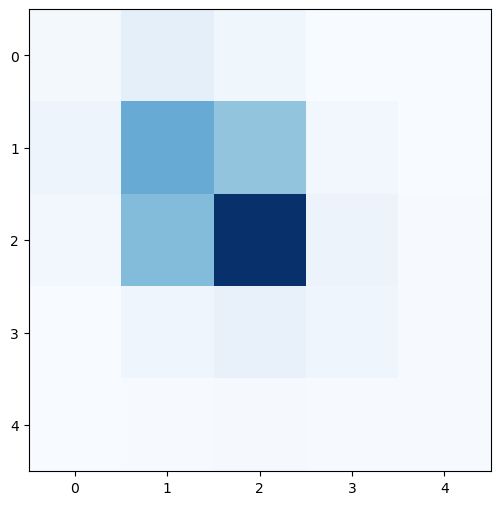

In [23]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, my_label, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)     
plt.show()

In [18]:
start = time.time() 

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[3,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10, 20]
    }


clf1 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)

clf1.fit(X_train, y_train)

# getting the best parameters ans score
print(clf1.best_params_)
print(clf1.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 20}
0.7447166921898928
time of execution (sec) 327.16247725486755


In [22]:
with open('GBK_model.pkl', 'wb') as fin:
    pickle.dump(clf1, fin)

In [19]:
my_label1Up=clf1.predict(X_test)

              precision    recall  f1-score   support

          -2       0.14      0.03      0.04       192
          -1       0.51      0.33      0.40      1291
           0       0.60      0.84      0.70      2001
           1       0.27      0.05      0.09       229
           2       0.15      0.07      0.10        43

    accuracy                           0.57      3756
   macro avg       0.33      0.26      0.27      3756
weighted avg       0.52      0.57      0.52      3756

[[   5   83  103    1    0]
 [  17  428  830   10    6]
 [  12  275 1688   17    9]
 [   2   36  177   12    2]
 [   0   11   25    4    3]]


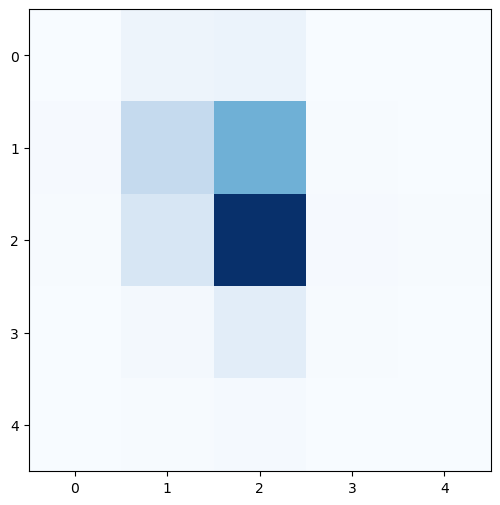

In [23]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, my_label1, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label1))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label1), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)    
plt.show()

              precision    recall  f1-score   support

          -2       0.83      0.83      0.83      1998
          -1       0.60      0.54      0.56      1945
           0       0.61      0.65      0.63      1938
           1       0.83      0.80      0.81      1992
           2       0.93      1.00      0.96      1922

    accuracy                           0.76      9795
   macro avg       0.76      0.76      0.76      9795
weighted avg       0.76      0.76      0.76      9795

[[1663  169   89   71    6]
 [ 209 1044  575  105   12]
 [  79  427 1256  146   30]
 [  58  112  139 1585   98]
 [   0    1    2    6 1913]]


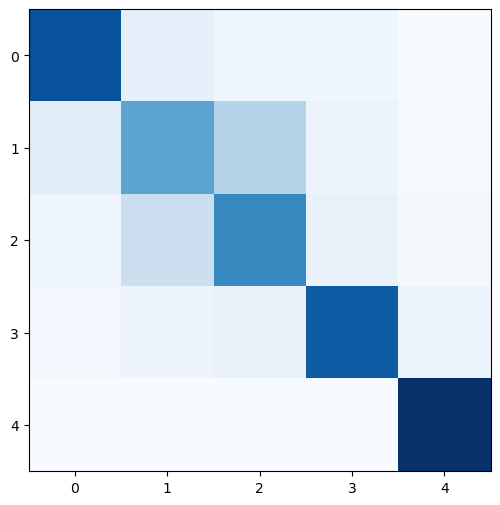

In [20]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, my_label1Up, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label1Up))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label1Up), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)   
plt.show()

In [37]:
model = AdaBoostClassifier(n_estimators=2, random_state=None, learning_rate=0.01)

mycv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

myparam_grid = {'learning_rate':[0.001, 0.01, 0.1],
               'n_estimators':[2, 10, 50, 100, 200]}

start = time.time()

clf3 = GridSearchCV(estimator=model, param_grid=myparam_grid, cv=mycv, n_jobs=-1)

clf3.fit(X_train, y_train)
print(clf3.best_params_)
print(clf3.best_score_)

stop = time.time()  
print('time of execution (sec)', stop - start)

{'learning_rate': 0.1, 'n_estimators': 200}
0.47313255062106513
time of execution (sec) 648.4543709754944


In [38]:
y_label3D=clf3.predict(X_test)

              precision    recall  f1-score   support

          -2       0.46      0.44      0.45      1998
          -1       0.40      0.34      0.37      1945
           0       0.49      0.48      0.49      1938
           1       0.38      0.54      0.44      1992
           2       0.73      0.55      0.63      1922

    accuracy                           0.47      9795
   macro avg       0.49      0.47      0.48      9795
weighted avg       0.49      0.47      0.47      9795

[[ 884  345  184  491   94]
 [ 419  671  516  309   30]
 [ 162  519  933  295   29]
 [ 311  139  233 1069  240]
 [ 150   11   32  671 1058]]


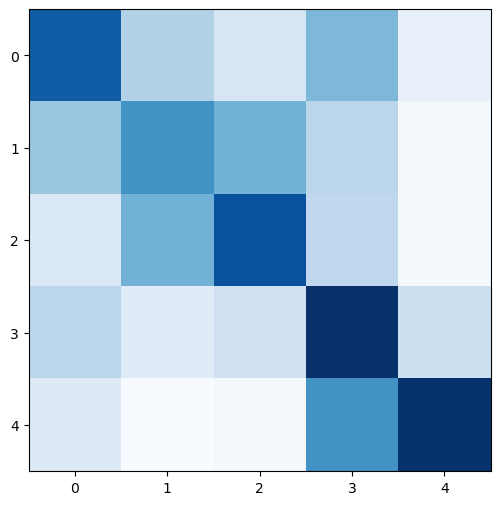

In [39]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, y_label3D, zero_division=0))
print(metrics.confusion_matrix(y_test, y_label3D))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, y_label3D), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)    
plt.show()

## Тестирование

In [24]:
# читаем данные из файла
f = 'test_data_exam_1.xlsx'
df1 = pd.read_excel(f, 0)  
print('Dataset size', df1.shape)
num_rows, num_feature = df1.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df1))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (8048, 2)
row number:  8048
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [7]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [27]:
y_data1 = []
lemm_data1 = []
morph = pymorphy2.MorphAnalyzer()
stop = set(stopwords.words("russian") + list(string.punctuation))

for i in tqdm(range(num_rows)):

    s2 = str(df1['original_data'][i])
    s12 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s2)
    word_list1 = nltk.word_tokenize(s12)
    for j in range(0,len(word_list1)):
        word_list1[j] = morph.parse(word_list1[j])[0].normal_form
    word_list1 = [w for w in word_list1 if not w in stop]  
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list1])
    lemm_data1.append(lemmatized_output)
    y_data1.append(word_list1)
    
print('Lematization is over')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 8048/8048 [03:55<00:00, 34.17it/s]

Lematization is over


In [28]:
# прежде всего полученный датасет data объеденим с Y.
df1["processed data"] = y_data1

neut_df1= df1[df1['score'] == 0]
neg_df1= df1[df1['score'] == -1]
pos_df1= df1[df1['score'] == 1]
super_neg_df1 = df1[df1['score'] == -2]
super_pos_df1= df1[df1['score'] == 2]

print(neut_df1.shape)
print(neg_df1.shape)
print(pos_df1.shape)
print(super_neg_df1.shape)
print(super_pos_df1.shape)

(4199, 3)
(2747, 3)
(524, 3)
(473, 3)
(105, 3)


In [29]:
print('neg_dataset before sampling: ', neg_df1.shape)

neg_downsample = resample(neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', neg_downsample.shape)

print('pos_dataset before sampling: ', pos_df1.shape)

pos_downsample = resample(pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('pos_dataset after sampling: ', pos_downsample.shape)

print('super_neg_dataset before sampling: ', super_neg_df1.shape)

super_neg_downsample = resample(super_neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('super_neg_dataset after sampling: ', super_neg_downsample.shape)

print('super_pos_dataset before sampling: ', super_pos_df1.shape)

super_pos_downsample = resample(super_pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', super_pos_downsample.shape)

neg_dataset before sampling:  (2747, 3)
neg_dataset after sampling:  (4199, 3)
pos_dataset before sampling:  (524, 3)
pos_dataset after sampling:  (4199, 3)
super_neg_dataset before sampling:  (473, 3)
super_neg_dataset after sampling:  (4199, 3)
super_pos_dataset before sampling:  (105, 3)
neg_dataset after sampling:  (4199, 3)


In [30]:
full_up_sample1 = pd.concat([super_neg_downsample, neg_downsample, neut_df1, pos_downsample, super_pos_downsample])
print(full_up_sample1.shape)

(20995, 3)


In [31]:
doc2vec_model = Doc2Vec.load("doc2vec2.model")

In [32]:
y_data1 = list(full_up_sample1["processed data"])
output = []
for d in y_data1:
    output.append(d2v_model.infer_vector(d))

In [33]:
goalY = full_up_sample1['score']

In [34]:
my_label1 = clf1.predict(output)

              precision    recall  f1-score   support

          -2       0.78      0.57      0.66      4199
          -1       0.45      0.47      0.46      4199
           0       0.42      0.67      0.52      4199
           1       0.68      0.56      0.62      4199
           2       0.92      0.73      0.81      4199

    accuracy                           0.60     20995
   macro avg       0.65      0.60      0.61     20995
weighted avg       0.65      0.60      0.61     20995

[[2381  941  727  126   24]
 [ 417 1978 1567  210   27]
 [ 176  868 2806  306   43]
 [  79  512 1066 2371  171]
 [  13  138  523  472 3053]]


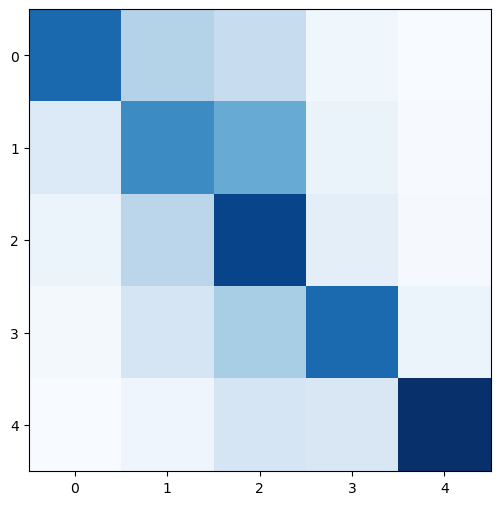

In [35]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(goalY, my_label1, zero_division=0))
print(metrics.confusion_matrix(goalY, my_label1))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(goalY, my_label1), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6) 
plt.show()

In [55]:
my_labelnew = clf1.predict(output)

              precision    recall  f1-score   support

          -2       0.41      0.64      0.49      4199
          -1       0.38      0.21      0.27      4199
           0       0.43      0.28      0.34      4199
           1       0.41      0.49      0.45      4199
           2       0.73      0.77      0.75      4199

    accuracy                           0.48     20995
   macro avg       0.47      0.48      0.46     20995
weighted avg       0.47      0.48      0.46     20995

[[2669  494  287  524  225]
 [1722  887  635  817  138]
 [1146  613 1160 1064  216]
 [ 847  273  399 2051  629]
 [ 202   67  209  502 3219]]


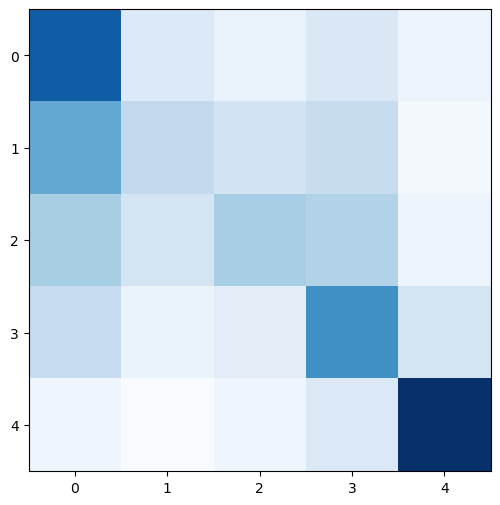

In [56]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(goalY, my_labelnew, zero_division=0))
print(metrics.confusion_matrix(goalY, my_labelnew))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(goalY, my_labelnew), cmap=cmap)
fig.set_figwidth(6)     
fig.set_figheight(6)    
plt.show()

In [40]:
my_labelnewAda= clf3.predict(output)

              precision    recall  f1-score   support

          -2       0.42      0.34      0.38      4199
          -1       0.35      0.36      0.36      4199
           0       0.36      0.47      0.41      4199
           1       0.33      0.45      0.38      4199
           2       0.74      0.38      0.50      4199

    accuracy                           0.40     20995
   macro avg       0.44      0.40      0.40     20995
weighted avg       0.44      0.40      0.40     20995

[[1424 1036  815  849   75]
 [ 690 1504 1403  570   32]
 [ 392 1080 1988  684   55]
 [ 470  507  946 1890  386]
 [ 386  128  433 1671 1581]]


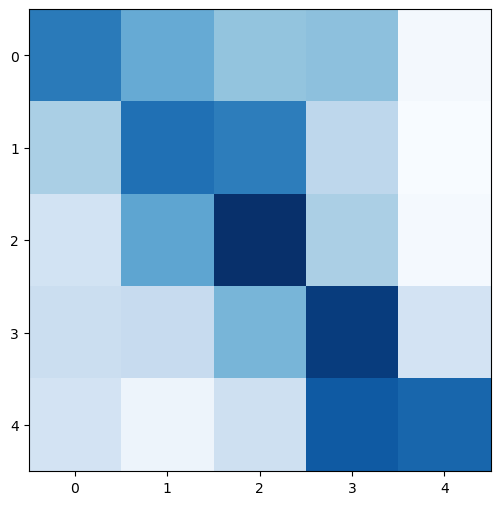

In [41]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(goalY, my_labelnewAda, zero_division=0))
print(metrics.confusion_matrix(goalY, my_labelnewAda))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(goalY, my_labelnewAda), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)    
plt.show()